In [52]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import math
import keras

In [4]:
data_df = pd.read_csv("fc_kp.csv")
data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,kp_index_x3
0,2016-01-01 00:00:00,5.512677,-2.305265,-13.208849,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000
1,2016-01-01 00:00:00,5.512677,-2.305265,-13.208849,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.000
2,2016-01-01 03:00:00,3.152941,-0.440106,-12.515978,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333
3,2016-01-01 03:00:00,3.152941,-0.440106,-12.515978,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.333
4,2016-01-01 06:00:00,3.226364,-5.161290,-8.537423,143.819967,103.094027,126.3402,129.49592,124.643217,96.82823,...,131.601167,151.2143,144.231933,129.541733,147.492067,156.671133,137.356233,158.362867,144.435267,5.000


In [5]:
len(data_df)

10626

In [36]:
df_filled = data_df.fillna(method='ffill').fillna(method='bfill')


In [22]:
#plotting function
def plot_col(df, start_date, end_date):
    # Filter rows between the desired dates

    filtered_data = df[(df['0'] >= start_date) & (df['0'] <= end_date)]

    # Plotting
    num_cols = 4  # number of graphs in each row
    num_rows = -(-len(filtered_data.columns[1:]) // num_cols)  # Calculate number of rows required

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*4))
    for i, col in enumerate(filtered_data.columns[1:], 1):  # start from the 2nd column as 1st column is 'date'
        ax = axes[(i-1) // num_cols][(i-1) % num_cols]
        ax.scatter(filtered_data['kp_index_x3'], filtered_data[col])
        ax.set_title(f'kp_index_x3 vs. {col}')
        ax.set_xlabel('kp_index_x3')
        ax.set_ylabel(col)

    # Remove any unused subplots
    for j in range(i, num_cols * num_rows):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

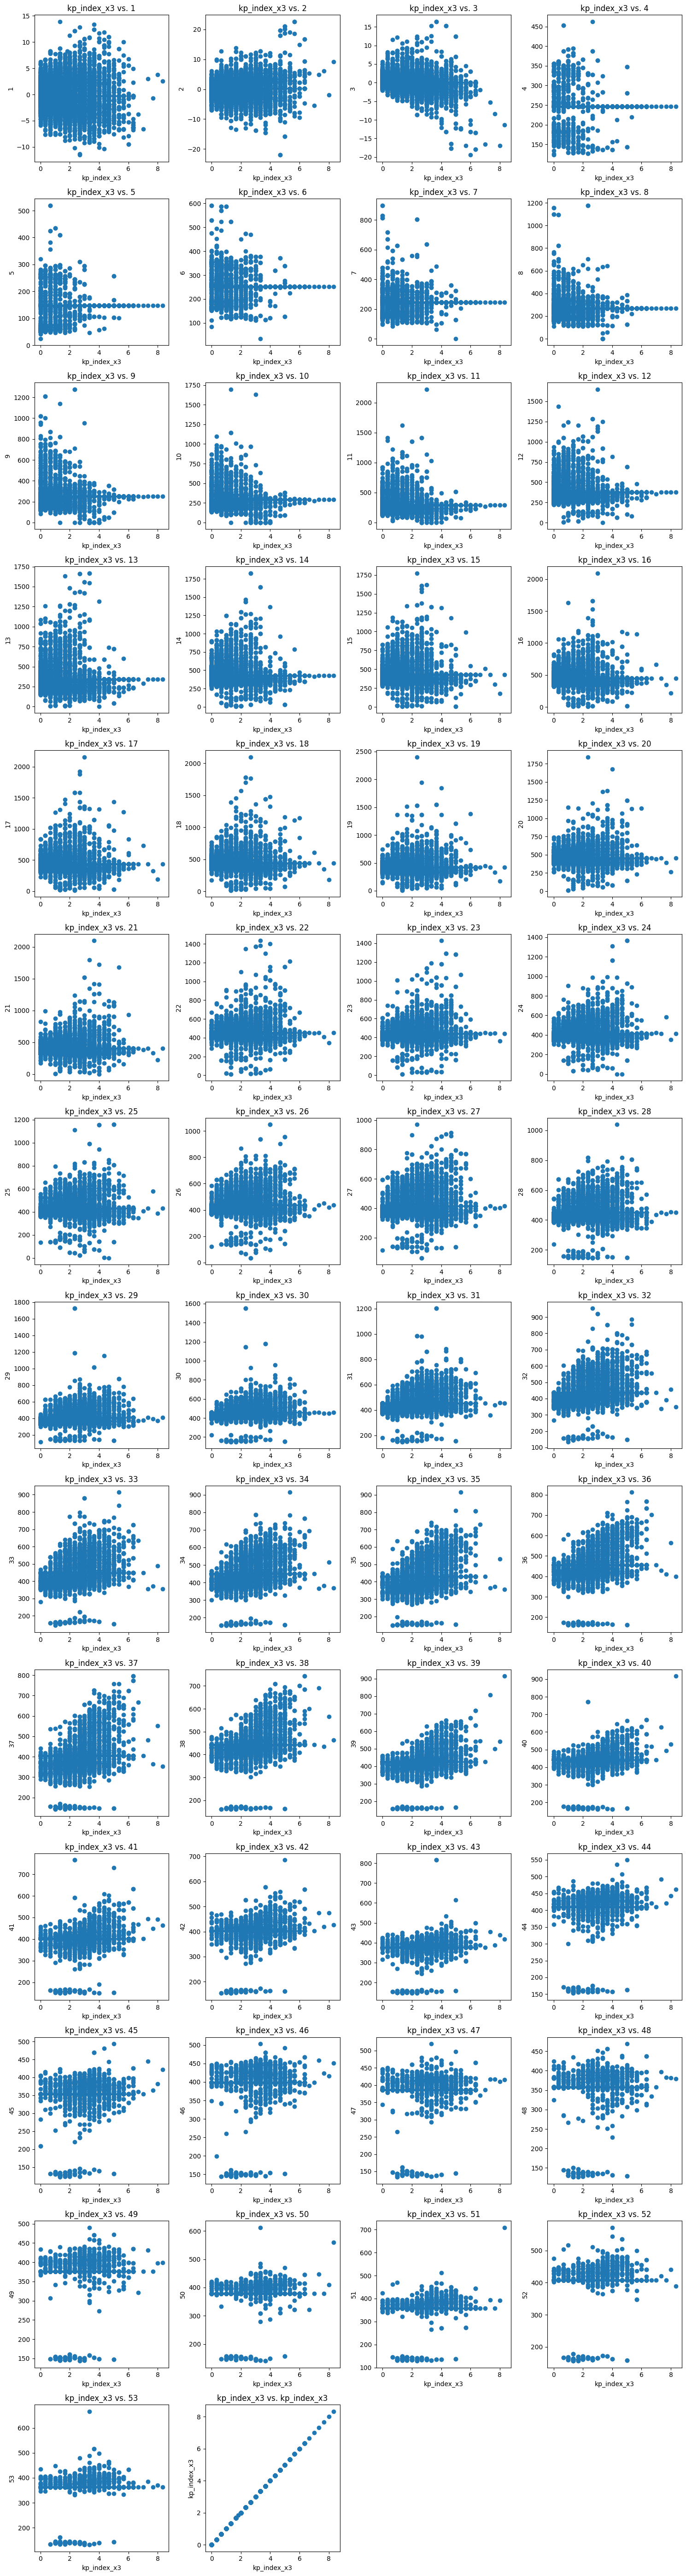

In [23]:
start_date = '2016-01-01 00:00:00'
end_date = '2019-06-27 21:00:00'
plot_col(df_filled, start_date, end_date)

In [26]:
val_test = df_filled['kp_index_x3'].values

In [27]:
len(val_test)

10626

In [28]:
from statsmodels.tsa.stattools import adfuller
ADF_result = adfuller(val_test)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -18.819696126472518
p-value: 2.0222155973372784e-30


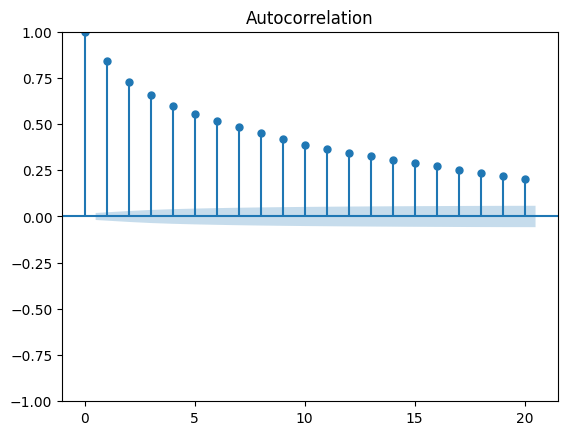

In [29]:
#therefore its stationary data
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(val_test, lags=20);

In [30]:
diff_close = np.diff(val_test, n=1)
val_result = adfuller(diff_close)
print(f'ADF Statistic: {val_result[0]}')
print(f'p-value: {val_result[1]}')


ADF Statistic: -25.363575897311296
p-value: 0.0


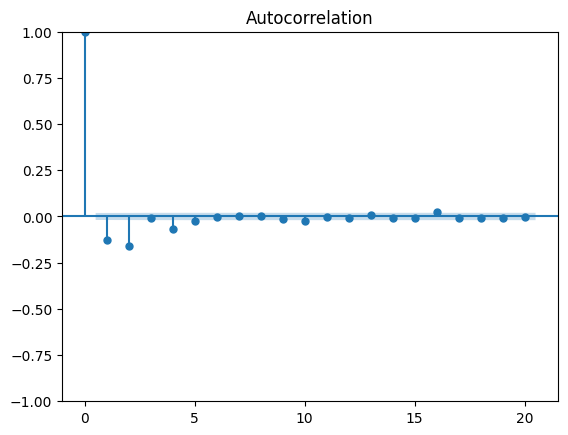

In [31]:
plot_acf(diff_close, lags=20);

In [32]:
import keras
import keras.layers as layers

In [64]:
def root_mean_squared_error(y_true, y_pred):
    return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

def build_model(input_shape=(53,)):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2), # Helps prevent overfitting
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1) # No activation for regression. For binary classification, use 'sigmoid'
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss=root_mean_squared_error,
                  metrics=[root_mean_squared_error, 'mae']) # Mean absolute error as a metric. For binary classification, you could use 'accuracy'

    return model

# Build and summarize the model
model_nn = build_model()
model_nn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 128)               6912      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_25 (Dense)            (None, 32)               

In [39]:
X = df_filled.iloc[:, 1:-1].values
y = df_filled.iloc[:, -1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Standardize the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=50, # Number of epochs with no improvement after which training will be stopped
                               verbose=1,
                               restore_best_weights=True) # Restore model weights from the epoch with the best value of the monitored quantity

# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 100:
        return 0.01
    elif epoch < 200:
        return 0.001
    else:
        return 0.0001

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

history = model_nn.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=500,
    batch_size=128,
    callbacks=[early_stopping, lr_scheduler]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/500
59/59 [==============================] - 2s 9ms/step - loss: 1.1491 - root_mean_squared_error: 1.1492 - mae: 0.8856 - val_loss: 1.1840 - val_root_mean_squared_error: 1.1838 - val_mae: 0.9094 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/500
59/59 [==============================] - 0s 5ms/step - loss: 1.0189 - root_mean_squared_error: 1.0196 - mae: 0.7912 - val_loss: 1.1206 - val_root_mean_squared_error: 1.1202 - val_mae: 0.8691 - lr: 0.0100

Epoch 3: LearningRateScheduler setting learning rate to 0.01.
Epoch 3/500
59/59 [==============================] - 0s 5ms/step - loss: 0.9827 - root_mean_squared_error: 0.9889 - mae: 0.7646 - val_loss: 1.0209 - val_root_mean_squared_error: 1.0206 - val_mae: 0.7965 - lr: 0.0100

Epoch 4: LearningRateScheduler setting learning rate to 0.01.
Epoch 4/500
59/59 [==============================] - 0s 5ms/step - loss: 0.9730 - root_mean_squared_

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [45]:
trainX.shape

(7438, 1, 53)

In [46]:
testX.shape

(3188, 1, 53)

In [68]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, 53)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, y_train, epochs=50, batch_size=64, verbose=2)

Epoch 1/50
117/117 - 2s - loss: 1.5794 - 2s/epoch - 21ms/step
Epoch 2/50
117/117 - 0s - loss: 0.9843 - 412ms/epoch - 4ms/step
Epoch 3/50
117/117 - 0s - loss: 0.9160 - 386ms/epoch - 3ms/step
Epoch 4/50
117/117 - 1s - loss: 0.8727 - 515ms/epoch - 4ms/step
Epoch 5/50
117/117 - 1s - loss: 0.8489 - 561ms/epoch - 5ms/step
Epoch 6/50
117/117 - 1s - loss: 0.8266 - 556ms/epoch - 5ms/step
Epoch 7/50
117/117 - 0s - loss: 0.8041 - 332ms/epoch - 3ms/step
Epoch 8/50
117/117 - 0s - loss: 0.8012 - 344ms/epoch - 3ms/step
Epoch 9/50
117/117 - 0s - loss: 0.7883 - 332ms/epoch - 3ms/step
Epoch 10/50
117/117 - 0s - loss: 0.7788 - 325ms/epoch - 3ms/step
Epoch 11/50
117/117 - 0s - loss: 0.7742 - 321ms/epoch - 3ms/step
Epoch 12/50
117/117 - 0s - loss: 0.7690 - 315ms/epoch - 3ms/step
Epoch 13/50
117/117 - 0s - loss: 0.7608 - 325ms/epoch - 3ms/step
Epoch 14/50
117/117 - 0s - loss: 0.7555 - 326ms/epoch - 3ms/step
Epoch 15/50
117/117 - 0s - loss: 0.7521 - 334ms/epoch - 3ms/step
Epoch 16/50
117/117 - 0s - loss: 0.7

In [56]:
print(model.metrics)

In [69]:
y_pred = model.predict(testX)

100/100 [==============================] - 1s 3ms/step


In [70]:
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")

rmse = math.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

r_squared = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r_squared:.2f}")


Mean Absolute Error (MAE): 0.66
Mean Squared Error (MSE): 0.78
Root Mean Squared Error (RMSE): 0.88
R-squared (R2): 0.54


In [71]:
pred_y_nn = model_nn.predict(X_test)

100/100 [==============================] - 0s 1ms/step


In [72]:
pred_list_nn = [i[0] for i in pred_y_nn]


In [73]:
actual = list(y_test)


In [74]:
for (x,y) in zip(actual, pred_list_nn):
  print("Actual: ", x, "\t\tPredicted ",y)

Actual:  3.333 		Predicted  2.8662124
Actual:  0.667 		Predicted  1.0686162
Actual:  0.0 		Predicted  0.688555
Actual:  2.0 		Predicted  2.0806124
Actual:  4.333 		Predicted  3.025268
Actual:  3.0 		Predicted  1.8703494
Actual:  1.333 		Predicted  1.8703494
Actual:  2.333 		Predicted  1.8077288
Actual:  3.667 		Predicted  2.2593043
Actual:  3.667 		Predicted  3.4800339
Actual:  2.0 		Predicted  1.8703494
Actual:  2.667 		Predicted  2.5388563
Actual:  2.0 		Predicted  1.8703494
Actual:  0.333 		Predicted  0.87562656
Actual:  0.333 		Predicted  1.8703494
Actual:  0.333 		Predicted  1.8703494
Actual:  1.333 		Predicted  1.7179775
Actual:  0.0 		Predicted  0.7505568
Actual:  1.0 		Predicted  1.6492224
Actual:  0.667 		Predicted  0.76557004
Actual:  1.0 		Predicted  1.4770799
Actual:  1.0 		Predicted  1.1475055
Actual:  3.0 		Predicted  2.4014683
Actual:  2.333 		Predicted  1.8703494
Actual:  1.333 		Predicted  1.3599238
Actual:  1.333 		Predicted  0.9503943
Actual:  0.667 		Predicted  1.87

In [75]:
pred_y_lstm = model.predict(testX)

100/100 [==============================] - 0s 2ms/step


In [76]:
pred_list_lstm = [i[0] for i in pred_y_lstm]


In [77]:
for (x,y) in zip(actual, pred_list_lstm):
  print("Actual: ", x, "\t\tPredicted_lstm ",y)

Actual:  3.333 		Predicted_lstm  2.8648374
Actual:  0.667 		Predicted_lstm  1.2090303
Actual:  0.0 		Predicted_lstm  0.46229064
Actual:  2.0 		Predicted_lstm  2.1168473
Actual:  4.333 		Predicted_lstm  3.611214
Actual:  3.0 		Predicted_lstm  1.9036499
Actual:  1.333 		Predicted_lstm  1.8454438
Actual:  2.333 		Predicted_lstm  1.5488045
Actual:  3.667 		Predicted_lstm  2.773463
Actual:  3.667 		Predicted_lstm  4.5978065
Actual:  2.0 		Predicted_lstm  1.9036499
Actual:  2.667 		Predicted_lstm  2.774369
Actual:  2.0 		Predicted_lstm  1.9036499
Actual:  0.333 		Predicted_lstm  0.81014633
Actual:  0.333 		Predicted_lstm  1.9036499
Actual:  0.333 		Predicted_lstm  1.9036499
Actual:  1.333 		Predicted_lstm  1.8012811
Actual:  0.0 		Predicted_lstm  0.35358438
Actual:  1.0 		Predicted_lstm  1.8105057
Actual:  0.667 		Predicted_lstm  0.8677157
Actual:  1.0 		Predicted_lstm  1.2463659
Actual:  1.0 		Predicted_lstm  1.1353627
Actual:  3.0 		Predicted_lstm  3.0128758
Actual:  2.333 		Predicted_lstm